In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from supporting_functions import *
import glob
import time
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, PredefinedSplit, cross_val_predict, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

from IPython.display import display

In [2]:
# create vehicle img list. We mark whether the data belongs to a certain GTI data directory.

vehicle_GTI_dirs = ['./data/vehicles/GTI_Far/', './data/vehicles/GTI_Left/', './data/vehicles/GTI_MiddleClose/', './data/vehicles/GTI_Right/']
vehicle_img_list = []
GTI_group_ids = []
cgroup_id = 1
for GTI_dir in vehicle_GTI_dirs:
    GTI_current_list = glob.glob(GTI_dir + '*.png')  
    vehicle_img_list = vehicle_img_list + GTI_current_list   
    GTI_group_ids = GTI_group_ids + [np.ones(len(GTI_current_list))*cgroup_id]
    cgroup_id += 1
KTTI_list = glob.glob('./data/vehicles/KITTI_extracted/*.png')
vehicle_img_list = vehicle_img_list+ KTTI_list
vehicle_group_id = np.concatenate(GTI_group_ids + [np.zeros(len(KTTI_list))])

# create non vehicle img list and group ids for non-vehicle data
non_vehicle_img_list = glob.glob('./data/non-vehicles/GTI/*.png') + glob.glob('./data/non-vehicles/Extras/*.png')
non_vehicle_group_id = np.zeros(len(non_vehicle_img_list))

# load all images
vehicle_images =  [(cv2_readRGB(w)) for w in vehicle_img_list]
non_vehicle_images =  [(cv2_readRGB(w)) for w in non_vehicle_img_list]


We ensure that the distribution of samples in test fold is consistent. The group calculation is done to handle the GTI data: The GTI images are from a sequences of images where adjacent images sometimes are the same car / truck. When calculating the fold index in cross validation, we make sure that consecutive images stay in the same fold except for a few images. This minimizes the possibility that the images for the same car ends up in both testing and training set. 

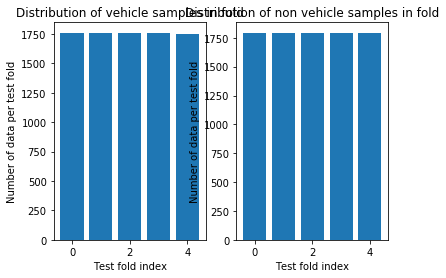

In [3]:
vehicle_fold_indices = obtain_fold_group(vehicle_group_id, 5)
non_vehicle_fold_indices = obtain_fold_group(non_vehicle_group_id, 5)
fold_indices = np.concatenate([vehicle_fold_indices, non_vehicle_fold_indices])
from scipy import stats
fold_dist = stats.itemfreq(vehicle_fold_indices)

plt.figure()
plt.subplot(121)
plt.bar(fold_dist[:,0], fold_dist[:,1])
plt.title('Distribution of vehicle samples in fold')
plt.xlabel('Test fold index')
plt.ylabel('Number of data per test fold')

plt.subplot(122)
fold_dist = stats.itemfreq(non_vehicle_fold_indices)
plt.bar(fold_dist[:,0], fold_dist[:,1])
plt.title('Distribution of non vehicle samples in fold')
plt.xlabel('Test fold index')
plt.ylabel('Number of data per test fold')
plt.savefig('./output_images/test_fold_distribution.png')

# Compre HOG Features
There are multiple choices of parameters for calculating HOG Features, including color representation and color channel, number of pixels per cell, number of cell per block and number of orientations. 
The number of cell per blcok should be at least (2 x 2) to address the shadow / variation of lighting conditions. On the other hand, using (3x3) number cells per block would approximately double the number of features required for (2x2), requiring larger number of samples. We will initialize with (2x2) and also perform an experiment with 3x3 to see if there is any advantage. 
The number of pixels per cell should be chosen so that 1. there are enough data point to form a orientation "histogram"; 2. There are enough spatial resolution to recognize the object of interest:

## Color Channels
We use the following setting and compare the performance of HOG features with linear SVM using different channels.
- orient = 8 # HOG orientations
- pix_per_cell = 8 # HOG pixels per cell
- cell_per_block = 2 # HOG cells per block

In [5]:
color_space_choice = ['RGB','HSV','LUV', 'YCrCb']
channel_choice = [[0],[1],[2],[0,1],[1,2],[0,2],[0,1,2]]
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = [0]# Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True #True # Spatial features on or off
hist_feat = True # True # Histogram features on or off
hog_feat = True # HOG features on or off

result = {}

for color_space in color_space_choice:
    for hog_channel in channel_choice:
        print((color_space, hog_channel))
        car_features = extract_features(vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        
        
        
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

        X_train_validate = X[fold_indices!=0,:]
        y_train_validate = y[fold_indices!=0]
        fold_train_validate = fold_indices[fold_indices!=0]        

        ss_clf = Pipeline([('ss', StandardScaler()), ('svc', LinearSVC())])
        # 
        t=time.time()
        train_scores, test_scores = validation_curve(ss_clf, X_train_validate, y_train_validate,
                                                     'svc__C', np.array([1.0]),
                                                     cv= PredefinedSplit(fold_train_validate), n_jobs=8)
        #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
        # Check the training time for the SVC                        
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train classifier...')
        # Check the score of the SVC
        print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
        print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
        # Check the prediction time for a single sample
        result[(color_space, str(hog_channel))] = {'train': train_scores,
                                                   'test': test_scores}

import pandas as pd
result_df_list = []
for key, val in result.items():
    result_df_list.append(pd.DataFrame({'train_accuracy': val['train'].mean(), 'train_std': val['train'].std(), 'test_accuracy': val['test'].mean(),
                                        'test_std': val['test'].std()}, index=[key]))
                 
    
result_df = pd.concat(result_df_list, axis=0)
result_df = result_df.sort_values('test_accuracy', ascending=False)      
result_df.to_csv('./output/color_space_comparison_histT_spatialT.csv')
display(result_df)

('RGB', [0])
11.54 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9715
('RGB', [1])
11.32 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9766
('RGB', [2])
11.57 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9737
('RGB', [0, 1])
19.71 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9784
('RGB', [1, 2])
18.94 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9766
('RGB', [0, 2])
19.81 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9761
('RGB', [0, 1, 2])
27.68 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9783
('HSV', [0])
12.12 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  

,test_accuracy,test_std,train_accuracy,train_std
"(LUV, [0, 1])",0.992820,0.001509,1.000000,0.000000
"(YCrCb, [0, 1, 2])",0.992538,0.001281,1.000000,0.000000
"(LUV, [0, 1, 2])",0.992468,0.001150,1.000000,0.000000
"(YCrCb, [0, 1])",0.992187,0.001714,1.000000,0.000000
"(HSV, [0, 2])",0.991975,0.000247,1.000000,0.000000
"(HSV, [0, 1, 2])",0.990004,0.000714,1.000000,0.000000
"(YCrCb, [0, 2])",0.988453,0.002074,1.000000,0.000000
"(LUV, [0, 2])",0.988243,0.001214,1.000000,0.000000
"(HSV, [1, 2])",0.988103,0.001204,1.000000,0.000000
"(HSV, [2])",0.984372,0.002508,1.000000,0.000000


## Other HOG Parameters
Using the top candidate color channels, we vary the other parameters

In [6]:
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True #True # Spatial features on or off
hist_feat = True # True # Histogram features on or off
hog_feat = True # HOG features on or off

result = {}
for color_choice in [('LUV', [0,1]), ('YCrCb', [0,1])]:    
    color_space = color_choice[0]
    hog_channel = color_choice[1]
    for pix_per_cell in [4, 8, 16]:
        for orient in [4,8,16]:
            for cell_per_block in [1,2,3]:
                print(color_choice)
                print((pix_per_cell, orient, cell_per_block))
                car_features = extract_features(vehicle_images, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)
                notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                        hist_feat=hist_feat, hog_feat=hog_feat)
                X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
                y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
                del car_features
                del notcar_features
                X_train_validate = X[fold_indices!=0,:]
                y_train_validate = y[fold_indices!=0]
                fold_train_validate = fold_indices[fold_indices!=0]        

                ss_clf = Pipeline([('ss', StandardScaler()), ('svc', LinearSVC())])
                # 
                t=time.time()
                train_scores, test_scores = validation_curve(ss_clf, X_train_validate, y_train_validate,
                                                             'svc__C', np.array([1.0]),
                                                             cv= PredefinedSplit(fold_train_validate), n_jobs=1)
                #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
                # Check the training time for the SVC                        
                t2 = time.time()
                print(round(t2-t, 2), 'Seconds to train classifier...')
                # Check the score of the SVC
                print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
                print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
                # Check the prediction time for a single sample
                result[(color_choice[0], str(color_choice[1]),pix_per_cell, orient, cell_per_block)] = {'train': train_scores,
                                                                                'test': test_scores,
                                                                                'feature_size': X.shape[1]}
result_df_list = []
for key, val in result.items():
    result_df_list.append(pd.DataFrame({'train_accuracy': val['train'].mean(), 'train_std': val['train'].std(), 'test_accuracy': val['test'].mean(),
                                        'test_std': val['test'].std(),
                                       'feature_size': val['feature_size']}, index=[key]))
                 
    
result_df = pd.concat(result_df_list, axis=0)
result_df = result_df.sort_values('test_accuracy', ascending=False)
result_df.to_csv('./output/hog_parameter_comparison_histT_spatialT.csv')
display(result_df)

('LUV', [0, 1])
(4, 4, 1)
34.95 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9802
('LUV', [0, 1])
(4, 4, 2)
107.43 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.982
('LUV', [0, 1])
(4, 4, 3)
53.57 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9816
('LUV', [0, 1])
(4, 8, 1)
54.24 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.993
('LUV', [0, 1])
(4, 8, 2)
39.82 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9921
('LUV', [0, 1])
(4, 8, 3)
80.03 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9915
('LUV', [0, 1])
(4, 16, 1)
20.92 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9942
('LUV', [0, 1])
(4, 16, 2)
81.7 Seconds t

,feature_size,test_accuracy,test_std,train_accuracy,train_std
"(YCrCb, [0, 1], 8, 16, 2)",7088,0.994439,0.000697,1.000000,0.000000
"(LUV, [0, 1], 4, 16, 2)",29616,0.994298,0.000757,1.000000,0.000000
"(LUV, [0, 1], 4, 16, 1)",9008,0.994227,0.000838,1.000000,0.000000
"(LUV, [0, 1], 16, 16, 2)",1968,0.994017,0.000700,1.000000,0.000000
"(LUV, [0, 1], 8, 16, 2)",7088,0.993947,0.001078,1.000000,0.000000
"(LUV, [0, 1], 16, 16, 3)",1968,0.993945,0.000840,1.000000,0.000000
"(LUV, [0, 1], 8, 16, 1)",2864,0.993805,0.000664,1.000000,0.000000
"(LUV, [0, 1], 8, 16, 3)",11184,0.993666,0.001278,1.000000,0.000000
"(YCrCb, [0, 1], 8, 16, 1)",2864,0.993523,0.001450,1.000000,0.000000
"(YCrCb, [0, 1], 8, 16, 3)",11184,0.993383,0.001133,1.000000,0.000000


# Observations:
The first observation is that a larger number of orientations (16) achieve generally achieves better performance than 8 orientations. 

Secondaly, the difference in performance among the top is small and  within the variation of the cross validation error. Amon gthem, the parameter the parameter (16,16,2) achieves good performance with considerably smaller number of features. 

## Spatial / Histogram Features

In [9]:
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True #True # Spatial features on or off
hist_feat = True # True # Histogram features on or off
hog_feat = True # HOG features on or off

result = {}
for color_choice in [('LUV', [0,1]), ('YCrCb', [0,1])]:    
    color_space = color_choice[0]
    hog_channel = color_choice[1]
    for spatial_feat in [False, True]:
        for hist_feat in [False, True]:
   
            print(color_choice)
            print((spatial_feat, hist_feat))
            car_features = extract_features(vehicle_images, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
            X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
            del car_features
            del notcar_features
            X_train_validate = X[fold_indices!=0,:]
            y_train_validate = y[fold_indices!=0]
            fold_train_validate = fold_indices[fold_indices!=0]        

            ss_clf = Pipeline([('ss', StandardScaler()), ('svc', LinearSVC())])
            # 
            t=time.time()
            train_scores, test_scores = validation_curve(ss_clf, X_train_validate, y_train_validate,
                                                         'svc__C', np.array([1.0]),
                                                         cv= PredefinedSplit(fold_train_validate), n_jobs=5)
            #X_train, X_test, y_train, y_test = train_test_split_with_GTI(scaled_X, y, group_id, test_size=0.2, random_state=0)
            # Check the training time for the SVC                        
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to train classifier...')
            # Check the score of the SVC
            print('Train Accuracy of Classifier = ', round(np.mean(train_scores), 4))
            print('Test Accuracy of Classifier = ', round(np.mean(test_scores), 4))
            # Check the prediction time for a single sample
            result[(color_choice[0], str(color_choice[1]),spatial_feat, hist_feat)] = {'train': train_scores,
                                                                            'test': test_scores,
                                                                            'feature_size': X.shape[1]}
result_df_list = []
for key, val in result.items():
    result_df_list.append(pd.DataFrame({'train_accuracy': val['train'].mean(), 'train_std': val['train'].std(), 'test_accuracy': val['test'].mean(),
                                        'test_std': val['test'].std(),
                                       'feature_size': val['feature_size']}, index=[key]))
                 
    
result_df = pd.concat(result_df_list, axis=0)
result_df = result_df.sort_values('test_accuracy', ascending=False)
result_df.to_csv('./output/hist_spatial_comparison.csv')
display(result_df)

('LUV', [0, 1])
(False, False)
25.45 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9876
('LUV', [0, 1])
(False, True)
24.43 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9923
('LUV', [0, 1])
(True, False)
21.16 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9934
('LUV', [0, 1])
(True, True)
18.95 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9939
('YCrCb', [0, 1])
(False, False)
23.33 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9893
('YCrCb', [0, 1])
(False, True)
22.84 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9929
('YCrCb', [0, 1])
(True, False)
12.92 Seconds to train classifier...
Train Accuracy of Classifier =  1.0
Test Accuracy of Classifier =  0.9938
('YCrC

,feature_size,test_accuracy,test_std,train_accuracy,train_std
"(YCrCb, [0, 1], True, True)",7088,0.994439,0.000697,1.0,0.0
"(LUV, [0, 1], True, True)",7088,0.993947,0.001078,1.0,0.0
"(YCrCb, [0, 1], True, False)",7040,0.993805,0.000717,1.0,0.0
"(LUV, [0, 1], True, False)",7040,0.993383,0.001079,1.0,0.0
"(YCrCb, [0, 1], False, True)",6320,0.992889,0.001832,1.0,0.0
"(LUV, [0, 1], False, True)",6320,0.992326,0.002008,1.0,0.0
"(YCrCb, [0, 1], False, False)",6272,0.989299,0.001542,1.0,0.0
"(LUV, [0, 1], False, False)",6272,0.987609,0.002475,1.0,0.0


## Extracted Features

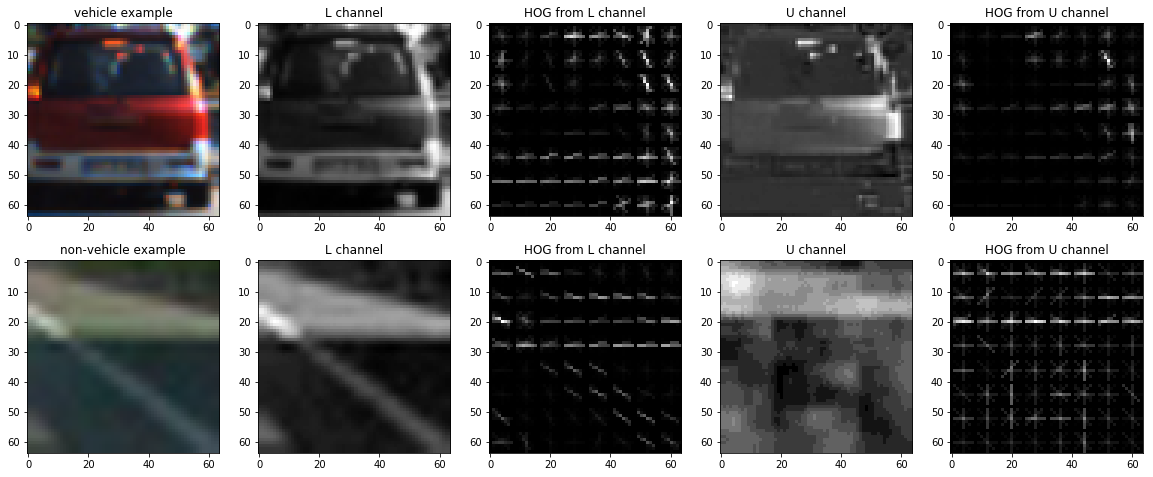

In [25]:
plt.figure(figsize=(20,8))
vehicle_example = cv2_readRGB('./data/vehicles/KITTI_extracted/32.png')
plt.subplot(2,5,1)
plt.imshow(vehicle_example)
plt.title('vehicle example')
jj=1

for hog_channel_current in [0,1]:
    jj += 1
    plt.subplot(2,5,jj)
    color_channel_img = convert_RGB_to_color_space(vehicle_example, 'LUV')[:,:,hog_channel_current]
    plt.imshow(color_channel_img, 'gray')
    plt.title('%s channel' % ('LUV')[hog_channel_current])

    jj += 1
    feature_example, hog_image_example = get_hog_features(color_channel_img,
                                                          orient=16, pix_per_cell=pix_per_cell, 
                                                          cell_per_block=2, 
                                                          vis=True)
    plt.subplot(2,5,jj)
    plt.imshow(hog_image_example, 'gray')  
    plt.title('HOG from %s channel' % ('LUV')[hog_channel_current])
    
non_vehicle_example = cv2_readRGB('./data/non-vehicles/GTI/image366.png')    
plt.subplot(2,5,6)
plt.imshow(non_vehicle_example)
plt.title('non-vehicle example')
jj=6


for hog_channel_current in [0,1]:
    jj += 1
    plt.subplot(2,5,jj)
    color_channel_img = convert_RGB_to_color_space(non_vehicle_example, 'LUV')[:,:,hog_channel_current]
    plt.imshow(color_channel_img, 'gray')
    plt.title('%s channel' % ('LUV')[hog_channel_current])

    jj += 1
    feature_example, hog_image_example = get_hog_features(color_channel_img,
                                                          orient=16, pix_per_cell=pix_per_cell, 
                                                          cell_per_block=2, 
                                                          vis=True)
    plt.subplot(2,5,jj)
    plt.imshow(hog_image_example, 'gray')  
    plt.title('HOG from %s channel' % ('LUV')[hog_channel_current])
    
plt.savefig('./output/HOG_feature_example.png')
    